In [1]:
!pip install spatialviewpy

May need to install following additional packages.

In [2]:
## If running in conda environment
# !conda install -c conda-forge python-annoy -y

# !pip install scanorama
# !pip install requests

In [3]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama

from spatialviewpy import prepare10x_from_scanpy

from os import listdir, path
from collections import OrderedDict

from scipy.io import mmwrite
from zipfile import ZipFile
import requests
import os
import shutil
import json
import gzip

import warnings
warnings.filterwarnings('ignore')

In this tutorial, we are using Spatial Transcriptomics (ST) data published in (Barkley *et al.*, 2022). This data contains multiple ST samples from different cancer types, such as breast, gastrointestinal, liver, ovary, pancreas, endometrium, and others. The data may be helpful to understand the heterogeneity in tumor micro environment (TME) among different cancer types. For this demonstration, we will be using ten samples (three breast, two gastrointestinal, one liver, two ovarian, one pancreas, and one endometrium) generated using 10x SpaceRanger. We will use Scanpy (Wolf *et al*., 2018) for data pre-processing and Scanorama (Hie *et al*., 2019) for integrating the samples. With the integrated data, we will do clustering followed by differential expression (DE) analysis to identify the marker genes of the clusters. Finally, we will export the analyzed data to SpatialView (Mohanty et al., 2023) for interactive visualization. Note that analysis steps are for demonstration purpose only.

[Check the running demo application](https://www.biostat.wisc.edu/~kendzior/spatialviewdemo/)

### Loading data

In [5]:
#path to data directory
data_path = "../../data_others/spatial/cancer_multi/GSE203612_RAW/"

sample_names = listdir(data_path)
sample_names = [d for d in sample_names if d[0] != '.']
sample_names = np.sort(sample_names)

sample_names

array(['BRCA0', 'BRCA1', 'BRCA2', 'GIST1', 'GIST2', 'LIHC1', 'OVCA1',
       'OVCA3', 'PDAC1', 'UCEC3'], dtype='<U5')

In [6]:
samples_dict = OrderedDict()
for samp in sample_names:
    adata = sc.read_10x_h5(path.join(data_path, samp, 'filtered_feature_bc_matrix.h5'))
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["rp"] = adata.var_names.str.startswith("RP[SL]")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt","rp"], inplace=True)
    samples_dict[samp] = adata

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
sample_info = pd.DataFrame({'sample': ["BRCA0", "BRCA1", "BRCA2", "GIST1",  
                                   "GIST2", "LIHC1", "OVCA1",  "OVCA3",  
                                   "PDAC1",   "UCEC3"],
                         'tissue' : ["breast", "breast", "breast", "gastrointestinal",
                                "gastrointestinal", "liver", "ovary", "ovary",
                                "pancreas", "endometrium"]}
                         )
sample_info

,sample,tissue
0,BRCA0,breast
1,BRCA1,breast
2,BRCA2,breast
3,GIST1,gastrointestinal
4,GIST2,gastrointestinal
5,LIHC1,liver
6,OVCA1,ovary
7,OVCA3,ovary
8,PDAC1,pancreas
9,UCEC3,endometrium


### Preprocessing and Normalization:
As a quality control step, spots with fewer than 500 UMIs or more than 30% mitochondrial or ribosomal reads were filtered out. Also, we are removing genes which has less than 5 num of spots.

Followed by data preprocessing, data is normalized.

In [8]:
for name, adata in samples_dict.items():
    sc.pp.filter_cells(adata, min_counts=500)
    adata = adata[adata.obs["pct_counts_mt"] < 30]
    adata = adata[adata.obs["pct_counts_rp"] < 30]
    sc.pp.filter_genes(adata, min_cells=5)
    
    sc.pp.normalize_total(adata, target_sum = 10000, inplace=True, copy= True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)
    samples_dict[name] = adata

In [9]:
# We will use the unscaled normalized data for data visualization, thus saving them in a layer
adata_norm = sc.concat(
    list(samples_dict.values()),
    label="sample_id",
    uns_merge="unique",
    index_unique="_",
    keys = samples_dict.keys()
)

### Data Integration

Data integrated using Scanorama.

In [10]:
adatas_cor = scanorama.correct_scanpy(list(samples_dict.values()), 
                                      return_dimred=True,
                                     sigma = 10)

Found 11047 genes among all datasets
[[0.         0.26403642 0.39789196 0.03920724 0.00131752 0.01668863
  0.16022727 0.00249169 0.02736318 0.03952569]
 [0.         0.         0.01820941 0.52200303 0.0030349  0.00856269
  0.01365706 0.05766313 0.12746586 0.03793627]
 [0.         0.         0.         0.0353296  0.         0.00214684
  0.08181818 0.00249169 0.05659204 0.00382848]
 [0.         0.         0.         0.         0.35341365 0.01406728
  0.00511364 0.08388704 0.18843284 0.02197329]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00808458 0.00229709]
 [0.         0.         0.         0.         0.         0.
  0.00568182 0.09302326 0.         0.00229709]
 [0.         0.         0.         0.         0.         0.
  0.         0.00083056 0.10447761 0.19772727]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00166113 0.78571429]
 [0.         0.         0.         0.         0.         0.
  0.         0.

In [11]:
samples_dict.keys()

odict_keys(['BRCA0', 'BRCA1', 'BRCA2', 'GIST1', 'GIST2', 'LIHC1', 'OVCA1', 'OVCA3', 'PDAC1', 'UCEC3'])

We will concatenating the two dataset with uns_merge="unique" strategy, in order to keep both images from the visium datasets in the concatenated anndata object following the step https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html

In [12]:
adata_spatial = sc.concat(
    adatas_cor,
    label="sample_id",
    uns_merge="unique",
    index_unique="_",
    keys = samples_dict.keys()
)


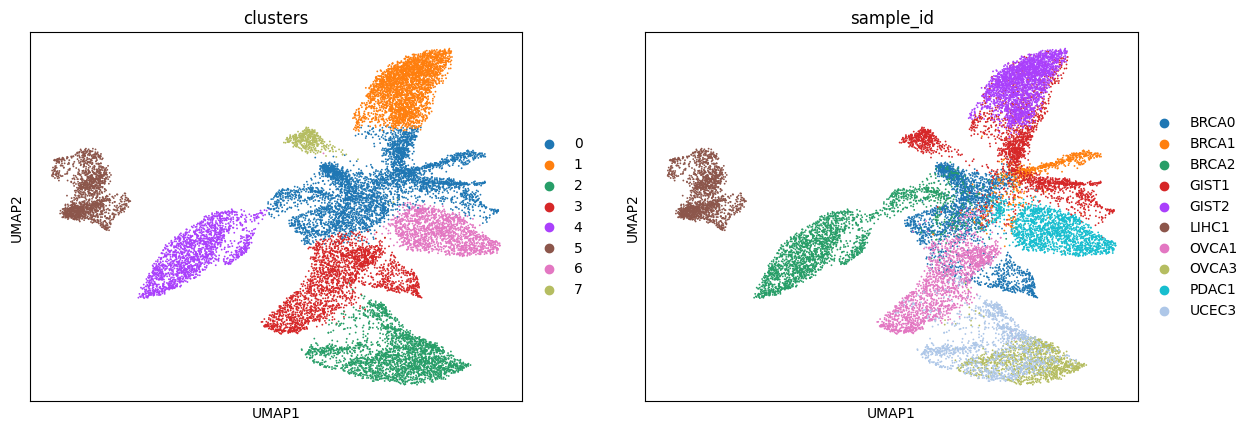

In [13]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial,resolution=0.15, key_added="clusters")

sc.pl.umap(
    adata_spatial, color=["clusters", "sample_id"], palette=sc.pl.palettes.default_20
)

In [14]:
adata_spatial.layers['normalized_counts'] = adata_norm.X

### DE test

In [15]:
sc.tl.rank_genes_groups(adata_spatial, 'clusters', layer = 'normalized_counts',
                        method='wilcoxon', key_added = "de_genes",
                       n_genes = 30)

ranked_genes = adata_spatial.uns['de_genes']['names']
de_genes = [','.join(ranked_genes[c]) for c in ranked_genes.dtype.names]


## Visualize using SpatialView

In [ ]:
sample_paths = [path.join(data_path, sample_name) for sample_name in sample_names]

prepare10x_from_scanpy(adata_spatial, data_paths = sample_paths,
                       export_path = "TME",
                       cluster_genes = de_genes,
                       layer = 'normalized_counts',
                       download_repo = True,
                       launch_app = True,
                       port = 8878,
                       verbose= True)

## Citations

1. Barkley, Dalia, Reuben Moncada, Maayan Pour, Deborah A. Liberman, Ian Dryg, Gregor Werba, Wei Wang, et al. 2022. “Cancer Cell States Recur Across Tumor Types and Form Specific Interactions with the Tumor Microenvironment.” Nature Genetics 54 (8): 1192–1201. https://doi.org/10.1038/s41588-022-01141-9.
2. Hao, Yuhan, Stephanie Hao, Erica Andersen-Nissen, William M. Mauck, Shiwei Zheng, Andrew Butler, Maddie J. Lee, et al. 2021. “Integrated Analysis of Multimodal Single-Cell Data.” Cell 184 (13): 3573–3587.e29. https://doi.org/10.1016/j.cell.2021.04.048.
3. Mohanty, Chitrasen, Aman Prasad, Lingxin Cheng, Lisa M. Arkin, Bridget E. Shields, Beth Drolet, and Christina Kendziorski. 2023. “SpatialView: An Interactive Web Application for Visualization of Multiple Samples in Spatial Transcriptomics Experiments.” http://dx.doi.org/10.1101/2023.06.13.544836.